In [1]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
%pip install pydlm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [3]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [4]:
%pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
#import data
df = pd.read_csv('../Datasets/INTC Historical Data.csv')

#print data 
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,36.60,36.61,36.93,36.27,20.20M,0.91%
1,1/4/2017,36.41,36.71,36.77,36.34,15.92M,-0.52%
2,1/5/2017,36.35,36.45,36.72,36.30,13.99M,-0.16%
3,1/6/2017,36.48,36.46,36.68,36.19,15.11M,0.36%
4,1/9/2017,36.61,36.48,36.88,36.48,19.46M,0.36%


In [7]:
#Bỏ dòng bị trống dự liệu
df = df.dropna()
#Chuyển đổi dữ liệu cột Vol. sang số
df['Vol.'] = df['Vol.'].str.replace('M', '').astype(float) * 1000000


In [8]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,1/3/2017,36.60,36.61,36.93,36.27,20200000.0,0.91%
1,1/4/2017,36.41,36.71,36.77,36.34,15920000.0,-0.52%
2,1/5/2017,36.35,36.45,36.72,36.30,13990000.0,-0.16%
3,1/6/2017,36.48,36.46,36.68,36.19,15110000.0,0.36%
4,1/9/2017,36.61,36.48,36.88,36.48,19460000.0,0.36%
...,...,...,...,...,...,...,...
1606,5/22/2023,30.28,29.85,30.45,29.82,28010000.0,1.17%
1607,5/23/2023,29.51,30.05,30.19,29.49,29310000.0,-2.54%
1608,5/24/2023,29.00,29.31,29.49,28.82,26580000.0,-1.73%
1609,5/25/2023,27.40,28.29,28.29,26.85,77200000.0,-5.52%


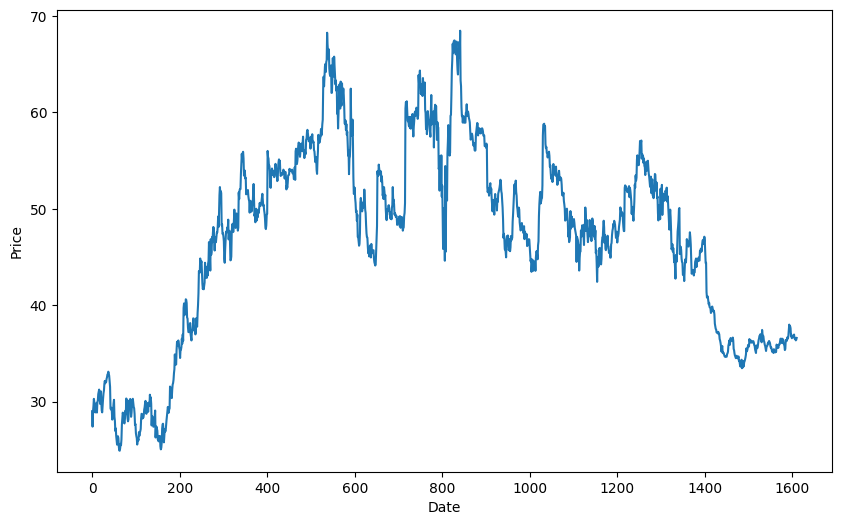

In [9]:
#Đảo ngược dữ liệu cho mô hình
df = df[::-1]

figure=df['Price'].values
plt.figure(figsize=(10,6))
plt.plot(figure)
plt.xlabel('Date')
plt.ylabel('Price') 
plt.show()

In [10]:
#Xây dựng mô hỉnh với Bayesian Dynamic Linear Model
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason


In [11]:
df = df.reset_index(drop=True)
 # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [12]:
from pydlm import dlm, trend, seasonality

# Tạo model DLM
my_dlm = dlm(train_data['Price'])

# Thêm trend component
my_dlm = my_dlm + trend(degree=1, name='trend', w=1.0)

# Thêm seasonality component với chu kỳ 52 tuần
my_dlm = my_dlm + seasonality(period=52, name='season', w=1.0)

In [13]:

# Fit the DLM to the training data
my_dlm.fit()


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [14]:
# Predict on validation set
my_dlm.predictN(N=30)


([49.08630846647323,
  49.36949197271764,
  49.06447607955802,
  48.672508006139616,
  48.87619007620971,
  48.76769187676097,
  48.37748083262773,
  49.71867317623515,
  50.09970985964434,
  50.49417990401096,
  50.62759267054995,
  50.40154137641515,
  50.23397732426032,
  49.11568514805583,
  49.20961935657716,
  48.6648420009587,
  48.623177168134696,
  48.558489150606135,
  49.596918473173666,
  48.832594601236295,
  48.77588033365863,
  49.034022072762895,
  48.73992942609188,
  48.13778651454291,
  48.297979967767674,
  47.999529325963145,
  48.14147897431362,
  47.844336781266726,
  47.82736432523452,
  47.33306638913887],
 [27.642909829269676,
  27.53357698455266,
  27.42525958082107,
  27.317947461385636,
  27.211630550366074,
  27.1062988529694,
  27.001942455739787,
  26.89855152678072,
  26.79611631594988,
  26.69462715502779,
  26.594074457860785,
  26.494448720478722,
  26.39574052118848,
  26.297940520643305,
  26.201039461889273,
  26.10502817038874,
  26.0098975540218

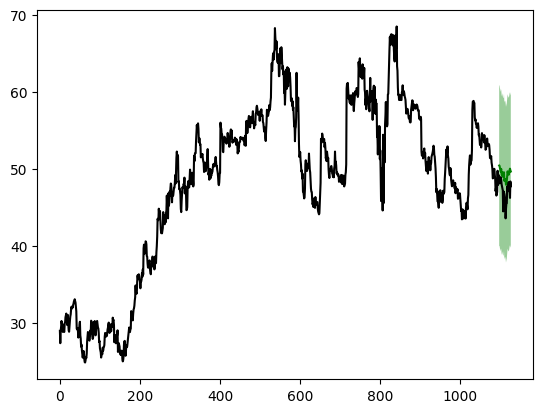

In [15]:
#Dự đoán trên tập train
my_dlm.plotPredictN(N=30, date=my_dlm.n-30)


In [16]:
# Predict on validation data
val_preds, val_vars = my_dlm.predictN(N=val_size)

# Predict on test data
test_preds, test_vars = my_dlm.predictN(N=test_size)
# Predict on train data
train_preds, train_vars = my_dlm.predictN(N=train_size)

In [17]:
# Các giá trị thực tế cho validation, test và train data
val_actual = val_data['Price'].values
test_actual = test_data['Price'].values
train_actual = train_data['Price'].values

In [18]:
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error

# Regression metrics
test_rmse = np.sqrt(np.mean((test_preds - test_actual)**2))
test_mse = mean_squared_error(test_actual, test_preds)
test_mae = mean_absolute_error(test_actual, test_preds)

valid_rmse = np.sqrt(np.mean((val_preds - val_actual)**2))
valid_mse = mean_squared_error(val_actual, val_preds)
valid_mae = mean_absolute_error(val_actual, val_preds)

print('Testing RMSE:', test_rmse)
print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)

print('Validation RMSE:', valid_rmse)
print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)

Testing RMSE: 4.737296043786101
Testing MSE: 22.44197380647144
Testing MAE: 3.7614202964913352
Validation RMSE: 11.365810277760552
Validation MSE: 129.1816432700474
Validation MAE: 11.190254006364864


In [20]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

In [21]:
# Dự đoán 30 ngày tiếp theo sau tập validation
future_preds, future_vars = my_dlm.predictN(N=30)

# In ra dự đoán cho 30 ngày tiếp theo
print("Predictions for the next 30 days:")
print(future_preds)

Predictions for the next 30 days:
[49.08630846647323, 49.36949197271764, 49.06447607955802, 48.672508006139616, 48.87619007620971, 48.76769187676097, 48.37748083262773, 49.71867317623515, 50.09970985964434, 50.49417990401096, 50.62759267054995, 50.40154137641515, 50.23397732426032, 49.11568514805583, 49.20961935657716, 48.6648420009587, 48.623177168134696, 48.558489150606135, 49.596918473173666, 48.832594601236295, 48.77588033365863, 49.034022072762895, 48.73992942609188, 48.13778651454291, 48.297979967767674, 47.999529325963145, 48.14147897431362, 47.844336781266726, 47.82736432523452, 47.33306638913887]


In [22]:
#Tạo một mảng chứa toàn bộ dữ liệu của tập train, validation và test
allPreds = np.concatenate([train_preds,test_preds, val_preds])


In [23]:
#Tạo mảng index tương ứng với tập allPreds
days = np.arange(0, len(allPreds))


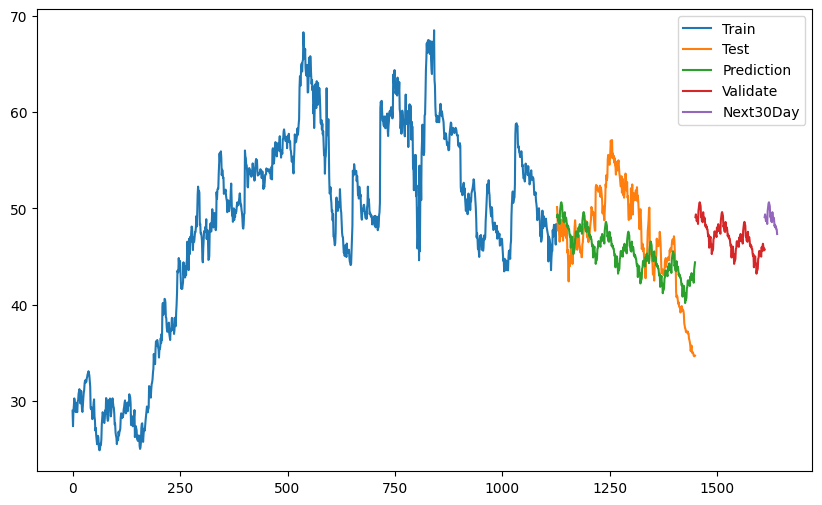

In [24]:
#Vẽ hình
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
#plt.plot(val_data.index, val_data['Price'])
plt.plot(days[len(train_data.index):len(train_data.index)+len(test_preds)], test_preds, label='Prediction')
plt.plot(days[len(train_data.index)+len(test_preds):], val_preds, label='Validate')
plt.plot(last_data,future_preds, label='Next30Day')

#plt.plot(pred_df.index, pred_df['Price'], label='Predicted')
plt.legend(['Train', 'Test', 'Prediction', 'Validate', 'Next30Day'])
plt.show()